<a href="https://colab.research.google.com/github/livjab/DS3-Kaggle-Comptetion/blob/master/Last_attempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


test = pd.read_csv("https://raw.githubusercontent.com/livjab/DS3-Kaggle-Comptetion/master/test_features.csv")
train = pd.read_csv("https://raw.githubusercontent.com/livjab/DS3-Kaggle-Comptetion/master/train_features.csv")
train_y = pd.read_csv("https://raw.githubusercontent.com/livjab/DS3-Kaggle-Comptetion/master/train_labels.csv")

X = train
y = train_y["status_group"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.80, test_size=0.20, stratify=y, random_state=42)



In [0]:
def clean(df):
  
  # turn zeros into NAN
  df['longitude'] = df['longitude'].replace(0.0, np.nan)
  df['latitude'] = df['latitude'].replace(0.0, np.nan)
  df["amount_tsh"] = df["amount_tsh"].replace(0.0, np.nan)
  df["construction_year"] = df["construction_year"].replace(0.0, np.nan)
  
  # dealing with those NANs
  df['longitude'].fillna(df['longitude'].mean(), inplace=True)
  df["latitude"].fillna(df["latitude"].mean(), inplace=True)
  df['amount_tsh'].fillna(df['amount_tsh'].median(), inplace=True)
  df['construction_year'].fillna(df['construction_year'].median(), inplace=True)
  
  # separating date into year/month/day
  df["date_recorded_sep"] = train["date_recorded"].str.split("-")
  
  # create new features for each
  df["year_recorded"] = pd.to_numeric(df["date_recorded_sep"].str[0])
  df["month_recorded"] = pd.to_numeric(df["date_recorded_sep"].str[1])
  df["day_of_month_recorded"] = pd.to_numeric(df["date_recorded_sep"].str[2])
  
  # drop separated column
  df = df.drop(columns="date_recorded_sep")
  
  
  # changing public_meeting to 0/1
  df["public_meeting"] = df.public_meeting.fillna(value="True")
  df["public_meeting"] = df.public_meeting.astype(bool).astype(int)
  
  # changing permit to 0/1
  df["permit"] = df.permit.fillna(value="True")
  df["permit"] = df.permit.astype(bool).astype(int)
  
  # Convert to lowercase to collapse duplicates
  df['waterpoint_type'] = df['waterpoint_type'].str.lower()
  df['funder'] = df['funder'].str.lower()
  df['basin'] = df['basin'].str.lower()
  df['region'] = df['region'].str.lower()
  df['source'] = df['source'].str.lower()
  df['lga'] = df['lga'].str.lower()
  df['management'] = df['management'].str.lower()
  df['quantity'] = df['quantity'].str.lower()
  df['quality_group'] = df['quality_group'].str.lower()
  df['payment_type'] = df['payment_type'].str.lower()
  
  
  # drop the following features due to repetition and/or insignificance
  df = df.drop(columns=["id", # random number
                        "recorded_by", # same entry in every row
                        "extraction_type", # basically a duplicate
                        "extraction_type_group", # another near duplicate
                        "payment", # has a near duplicate
                        "water_quality", # has a near duplicate
                        "quantity_group", # has an exact duplicate
                        "source_type", # heas a near duplicate
                        "waterpoint_type_group"]) # has a near duplicate
  
  # feature engineering
  
  # create age
  df["age_of_pump"] = df["year_recorded"] - df["construction_year"]
  
  # water per person
  df["water_per_person"] = df["amount_tsh"] / df["population"]
  

  return df

In [3]:
X_train = clean(X_train)
X_test  = clean(X_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

In [0]:
test = clean(test)
train = clean(train)

In [5]:
train.shape, test.shape

((59400, 36), (14358, 36))

In [6]:
!pip install category_encoders

In [8]:
import category_encoders as ce
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)

param_distributions = {
    'n_estimators': randint(100, 300), 
    'max_depth': [5, 6, 7, 8]
}

search = RandomizedSearchCV(
    estimator=XGBClassifier(n_jobs=-1, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=8, 
    scoring='accuracy', 
    n_jobs=-1, 
    cv=3, 
    verbose=10, 
    return_train_score=True, 
    random_state=42
)

search.fit(X_train.values, y_train.values)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  9.1min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 15.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 15.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=42, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=True,
                                           subsample=1),
                   iid='warn', n_iter=8, n_jobs=-1,
                   param_distrib

In [9]:
best = search.best_estimator_
best

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=None, n_estimators=279,
              n_jobs=-1, nthread=None, objective='multi:softprob',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [10]:
search.best_score_

0.7593644781144782

In [11]:
pd.DataFrame(search.cv_results_).sort_values(by="rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,123.060908,1.003095,2.223356,0.184126,7,279,"{'max_depth': 7, 'n_estimators': 279}",0.796175,0.798725,0.683187,0.759364,0.053873,1,0.910790,0.906095,0.897636,0.904840,0.005443
2,77.278216,0.776274,1.045443,0.100286,7,171,"{'max_depth': 7, 'n_estimators': 171}",0.792261,0.795694,0.685586,0.757849,0.051115,2,0.875844,0.868975,0.865661,0.870160,0.004241
5,78.344776,0.960731,1.097589,0.075969,7,174,"{'max_depth': 7, 'n_estimators': 174}",0.792640,0.795757,0.685144,0.757849,0.051424,2,0.876981,0.870111,0.866608,0.871233,0.004308
4,98.611247,0.681351,1.532910,0.037379,7,221,"{'max_depth': 7, 'n_estimators': 221}",0.794092,0.796767,0.682051,0.757639,0.053458,4,0.894059,0.889176,0.879707,0.887648,0.005958
6,84.067113,0.405770,1.267729,0.063538,7,187,"{'max_depth': 7, 'n_estimators': 187}",0.792450,0.795694,0.683440,0.757197,0.052169,5,0.880706,0.873773,0.869827,0.874769,0.004497


36


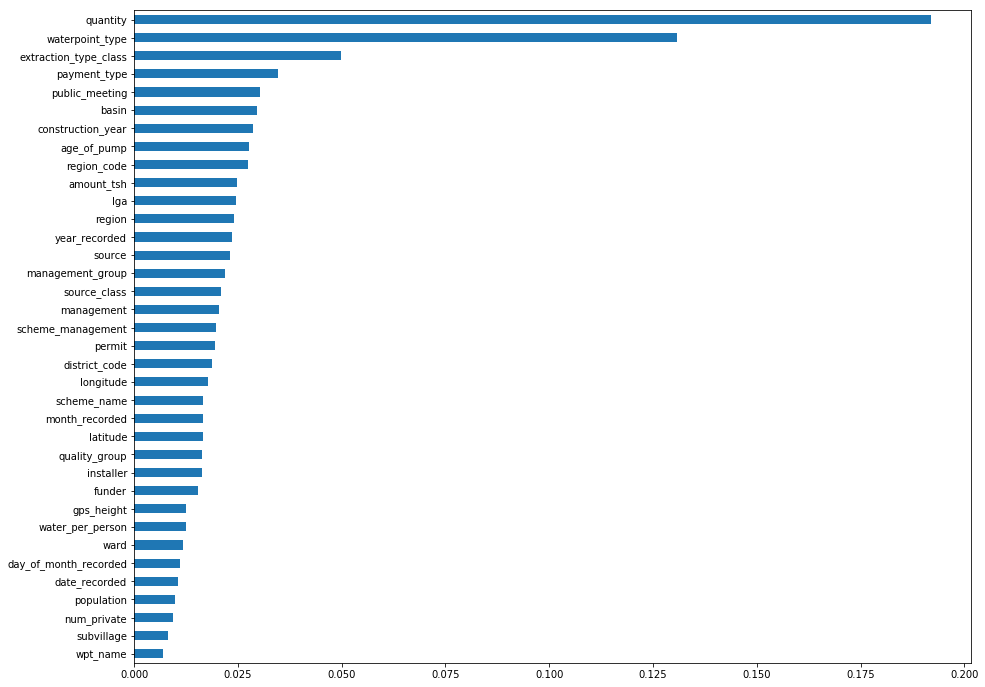

In [12]:
importances = pd.Series(best.feature_importances_, X_train.columns)
top_n = importances.sort_values(ascending=True)
plt.figure(figsize=(15,12))
top_n.plot.barh();
print(len(top_n))

In [13]:
!pip install eli5

     |████████████████████████████████| 102kB 1.8MB/s 


In [0]:

import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(best, scoring="accuracy", cv="prefit", n_iter=2, random_state=42 )

permuter.fit(X_test.values, y_test)

In [23]:
feature_names = X_test.columns.tolist()

eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.1262 ± 0.0011,quantity
0.0516 ± 0.0028,waterpoint_type
0.0425 ± 0.0003,extraction_type_class
0.0397 ± 0.0007,longitude
0.0346 ± 0.0007,latitude
0.0257 ± 0.0019,lga
0.0217 ± 0.0009,payment_type
0.0205 ± 0.0009,population
0.0179 ± 0.0017,subvillage
0.0176 ± 0.0011,ward


In [0]:
#features I want to use

# ['quantity', 'waterpoint_type', "extraction_type_class", "payment_type", "lga",
# "latitude", "longitude", "amount_tsh", "age_of_pump"]

In [18]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate


features = ['quantity', 'waterpoint_type', "extraction_type_class", 
            "payment_type", "lga", "latitude", "longitude", "amount_tsh", 
            "age_of_pump"]
target = "status_group"

X_train = train[features]
y_train = train_y[target]
X_test = test[features]

imputer = SimpleImputer(strategy="most_frequent")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

scores = cross_validate(XGBClassifier(max_depth=7, n_estimators=200),
                       X_train,
                       y_train,
                       scoring="accuracy",
                       cv=3,
                       return_train_score=True,
                       return_estimator=True)

pd.DataFrame(scores)


,fit_time,score_time,estimator,test_score,train_score
0,28.809056,1.251362,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.783232,0.832020
1,28.676943,1.370707,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.785051,0.828914
2,28.852815,1.228417,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.784444,0.829419


In [19]:
# gonna keep iterating on this model
# this one with no scaler

features = ['quantity', 'waterpoint_type', "extraction_type_class", 
            "payment_type", "lga", "latitude", "longitude", "amount_tsh", 
            "age_of_pump"]
target = "status_group"

X_train = train[features]
y_train = train_y[target]
X_test = test[features]

imputer = SimpleImputer(strategy="most_frequent")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

scores = cross_validate(XGBClassifier(max_depth=7, n_estimators=200),
                       X_train,
                       y_train,
                       scoring="accuracy",
                       cv=3,
                       return_train_score=True,
                       return_estimator=True)

pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,28.766448,1.185243,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.783081,0.831061
1,28.765789,1.157647,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.784596,0.827727
2,28.483968,1.406555,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.783434,0.829798


In [22]:
# not much of a difference
# lets tweak simple imputer

features = ['quantity', 'waterpoint_type', "extraction_type_class", 
            "payment_type", "lga", "latitude", "longitude", "amount_tsh", 
            "age_of_pump"]
target = "status_group"

X_train = train[features]
y_train = train_y[target]
X_test = test[features]

imputer = SimpleImputer(strategy="constant", fill_value="other")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

scores = cross_validate(XGBClassifier(max_depth=7, n_estimators=200),
                       X_train,
                       y_train,
                       scoring="accuracy",
                       cv=3,
                       return_train_score=True,
                       return_estimator=True)

pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,28.780923,1.185916,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.783232,0.832020
1,29.254588,1.282405,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.785051,0.828914
2,28.582628,1.268157,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.784444,0.829419


In [23]:
# lets mess with max_depth

features = ['quantity', 'waterpoint_type', "extraction_type_class", 
            "payment_type", "lga", "latitude", "longitude", "amount_tsh", 
            "age_of_pump"]
target = "status_group"

X_train = train[features]
y_train = train_y[target]
X_test = test[features]

imputer = SimpleImputer(strategy="constant", fill_value="other")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

scores = cross_validate(XGBClassifier(max_depth=8, n_estimators=200),
                       X_train,
                       y_train,
                       scoring="accuracy",
                       cv=3,
                       return_train_score=True,
                       return_estimator=True)

pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,32.631371,1.556707,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.787929,0.852222
1,32.342464,1.581820,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.789596,0.849394
2,32.249288,1.413994,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.789394,0.848485


In [0]:
# so far this (^) is the one to beat


In [24]:

features = ['quantity', 'waterpoint_type', "extraction_type_class", 
            "payment_type", "lga", "latitude", "longitude", "amount_tsh", 
            "age_of_pump"]
target = "status_group"

X_train = train[features]
y_train = train_y[target]
X_test = test[features]

imputer = SimpleImputer(strategy="constant", fill_value="other")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

scores = cross_validate(XGBClassifier(max_depth=6, n_estimators=200),
                       X_train,
                       y_train,
                       scoring="accuracy",
                       cv=3,
                       return_train_score=True,
                       return_estimator=True)

pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,25.684895,0.991120,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.776566,0.809318
1,24.362040,1.045096,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.777626,0.810303
2,24.378101,0.897677,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.776768,0.810556


In [25]:
# going to play with feature selection
# removing lga

features = ['quantity', 'waterpoint_type', "extraction_type_class", 
            "payment_type", "latitude", "longitude", "amount_tsh", 
            "age_of_pump"]
target = "status_group"

X_train = train[features]
y_train = train_y[target]
X_test = test[features]

imputer = SimpleImputer(strategy="constant", fill_value="other")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

scores = cross_validate(XGBClassifier(max_depth=8, n_estimators=200),
                       X_train,
                       y_train,
                       scoring="accuracy",
                       cv=3,
                       return_train_score=True,
                       return_estimator=True)

pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,30.443543,1.588026,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.786970,0.851995
1,30.339638,1.536763,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.786768,0.844545
2,30.715755,1.568455,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.783990,0.848232


In [27]:
# slightly lower scores, trying again with removing amount_tsh and age_of_pump

features = ['quantity', 'waterpoint_type', "extraction_type_class", 
            "payment_type", "lga", "latitude", "longitude"]
target = "status_group"

X_train = train[features]
y_train = train_y[target]
X_test = test[features]

imputer = SimpleImputer(strategy="constant", fill_value="other")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

scores = cross_validate(XGBClassifier(max_depth=8, n_estimators=200),
                       X_train,
                       y_train,
                       scoring="accuracy",
                       cv=3,
                       return_train_score=True,
                       return_estimator=True)

pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,29.084163,1.453339,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.783838,0.844722
1,28.266091,1.445032,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.781061,0.840884
2,29.053607,1.590361,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.777626,0.845404


In [28]:
# worse, lets add them back in and add population

features = ['quantity', 'waterpoint_type', "extraction_type_class", 
            "payment_type", "lga", "latitude", "longitude", "amount_tsh", 
            "age_of_pump", "population"]
target = "status_group"

X_train = train[features]
y_train = train_y[target]
X_test = test[features]

imputer = SimpleImputer(strategy="constant", fill_value="other")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

scores = cross_validate(XGBClassifier(max_depth=8, n_estimators=200),
                       X_train,
                       y_train,
                       scoring="accuracy",
                       cv=3,
                       return_train_score=True,
                       return_estimator=True)

pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,35.240108,1.527592,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.791010,0.860328
1,34.398813,1.375413,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.793990,0.858788
2,34.958999,1.461704,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.792273,0.857652


In [0]:
# new highest score (^) ! 

In [38]:
# maybe let's add in a few more and see what happens

features = ['quantity', 'waterpoint_type', "extraction_type_class", 
            "payment_type", "lga", "latitude", "longitude", "amount_tsh", 
            "age_of_pump", "population", "public_meeting"]
target = "status_group"

X_train = train[features]
y_train = train_y[target]
X_test = test[features]

imputer = SimpleImputer(strategy="constant", fill_value="other")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

scores = cross_validate(XGBClassifier(max_depth=8, n_estimators=200),
                       X_train,
                       y_train,
                       scoring="accuracy",
                       cv=3,
                       return_train_score=True,
                       return_estimator=True)

pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,37.120544,1.596642,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.794545,0.861667
1,36.511139,1.577164,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.794141,0.859495
2,36.589459,1.569587,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.793384,0.859975


In [0]:
# the one to beat (^)
# lets go ahead and submit this one before continueing to iterate

In [0]:
boost = XGBClassifier(max_depth=8, n_estimators=200)
boost.fit(X_train, y_train)

y_pred = boost.predict(X_test)

sample_submission = pd.read_csv('https://raw.githubusercontent.com/livjab/DS3-Kaggle-Comptetion/master/sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred

from google.colab import files
submission.to_csv('LJ-tenth-submission.csv', index=False)
files.download('LJ-tenth-submission.csv')

In [48]:
features = ['quantity', 'waterpoint_type', "extraction_type_class", 
            "payment_type", "lga", "latitude", "longitude", "amount_tsh", 
            "age_of_pump", "population", "public_meeting"]
target = "status_group"

X_train = train[features]
y_train = train_y[target]
X_test = test[features]

imputer = SimpleImputer(strategy="constant", fill_value="other")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

scores = cross_validate(XGBClassifier(max_depth=8, n_estimators=280),
                       X_train,
                       y_train,
                       scoring="accuracy",
                       cv=3,
                       return_train_score=True,
                       return_estimator=True)

pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,50.296255,2.395504,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.796313,0.877955
1,50.133349,2.391222,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.795404,0.878813
2,50.324916,2.366510,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.793737,0.876035


In [0]:
boost = XGBClassifier(max_depth=8, n_estimators=280)
boost.fit(X_train, y_train)

y_pred = boost.predict(X_test)

sample_submission = pd.read_csv('https://raw.githubusercontent.com/livjab/DS3-Kaggle-Comptetion/master/sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred

from google.colab import files
submission.to_csv('LJ-eleventh-submission.csv', index=False)
files.download('LJ-eleventh-submission.csv')

In [47]:
# slightly better when I increased estimators
# lets play with a few more parameters

features = ['quantity', 'waterpoint_type', "extraction_type_class", 
            "payment_type", "lga", "latitude", "longitude", "amount_tsh", 
            "age_of_pump", "population", "public_meeting"]
target = "status_group"

X_train = train[features]
y_train = train_y[target]
X_test = test[features]

imputer = SimpleImputer(strategy="constant", fill_value="other")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

scores = cross_validate(XGBClassifier(max_depth=8, n_estimators=280, booster="dart"),
                       X_train,
                       y_train,
                       scoring="accuracy",
                       cv=3,
                       return_train_score=True,
                       return_estimator=True)

pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,693.296307,2.721242,"XGBClassifier(base_score=0.5, booster='dart', ...",0.795202,0.879040
1,670.573945,2.634070,"XGBClassifier(base_score=0.5, booster='dart', ...",0.795404,0.878813
2,670.101717,2.520607,"XGBClassifier(base_score=0.5, booster='dart', ...",0.793737,0.876035


In [31]:
# moving up more, lets keep adding features

features = ['quantity', 'waterpoint_type', "extraction_type_class", 
            "payment_type", "lga", "latitude", "longitude", "amount_tsh", 
            "age_of_pump", "population", "public_meeting", "basin"]
target = "status_group"

X_train = train[features]
y_train = train_y[target]
X_test = test[features]

imputer = SimpleImputer(strategy="constant", fill_value="other")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

scores = cross_validate(XGBClassifier(max_depth=8, n_estimators=200),
                       X_train,
                       y_train,
                       scoring="accuracy",
                       cv=3,
                       return_train_score=True,
                       return_estimator=True)

pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,38.995226,1.532762,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.791818,0.863359
1,38.166526,1.447975,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.791869,0.860177
2,38.323519,1.675802,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.791111,0.859722


In [32]:
# nope, get that basin outta here

features = ['quantity', 'waterpoint_type', "extraction_type_class", 
            "payment_type", "lga", "latitude", "longitude", "amount_tsh", 
            "age_of_pump", "population", "public_meeting", "construction_year"]
target = "status_group"

X_train = train[features]
y_train = train_y[target]
X_test = test[features]

imputer = SimpleImputer(strategy="constant", fill_value="other")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

scores = cross_validate(XGBClassifier(max_depth=8, n_estimators=200),
                       X_train,
                       y_train,
                       scoring="accuracy",
                       cv=3,
                       return_train_score=True,
                       return_estimator=True)

pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,39.929792,1.577477,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.792323,0.861616
1,39.710107,1.721735,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.792071,0.860253
2,39.177382,1.489040,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.792121,0.861667


In [34]:
# construction_year not helping.
# I am tapping out on feature selection

# going to experiment with different types of scalers
from sklearn.preprocessing import RobustScaler

features = ['quantity', 'waterpoint_type', "extraction_type_class", 
            "payment_type", "lga", "latitude", "longitude", "amount_tsh", 
            "age_of_pump", "population", "public_meeting"]
target = "status_group"

X_train = train[features]
y_train = train_y[target]
X_test = test[features]

imputer = SimpleImputer(strategy="constant", fill_value="other")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

scores = cross_validate(XGBClassifier(max_depth=8, n_estimators=200),
                       X_train,
                       y_train,
                       scoring="accuracy",
                       cv=3,
                       return_train_score=True,
                       return_estimator=True)

pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,37.230680,1.648774,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.793384,0.860707
1,37.408155,1.565171,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.793182,0.859975
2,37.367324,1.610516,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.793384,0.859975


In [35]:
# pretty similar, lets try another
from sklearn.preprocessing import MinMaxScaler

features = ['quantity', 'waterpoint_type', "extraction_type_class", 
            "payment_type", "lga", "latitude", "longitude", "amount_tsh", 
            "age_of_pump", "population", "public_meeting"]
target = "status_group"

X_train = train[features]
y_train = train_y[target]
X_test = test[features]

imputer = SimpleImputer(strategy="constant", fill_value="other")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

scores = cross_validate(XGBClassifier(max_depth=8, n_estimators=200),
                       X_train,
                       y_train,
                       scoring="accuracy",
                       cv=3,
                       return_train_score=True,
                       return_estimator=True)

pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,37.260364,1.526356,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.792576,0.860833
1,36.609389,1.570430,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.793232,0.859823
2,36.543110,1.645085,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.791717,0.858914


In [36]:
from sklearn.preprocessing import PowerTransformer

features = ['quantity', 'waterpoint_type', "extraction_type_class", 
            "payment_type", "lga", "latitude", "longitude", "amount_tsh", 
            "age_of_pump", "population", "public_meeting"]
target = "status_group"

X_train = train[features]
y_train = train_y[target]
X_test = test[features]

imputer = SimpleImputer(strategy="constant", fill_value="other")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

scaler = PowerTransformer()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

scores = cross_validate(XGBClassifier(max_depth=8, n_estimators=200),
                       X_train,
                       y_train,
                       scoring="accuracy",
                       cv=3,
                       return_train_score=True,
                       return_estimator=True)

pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,36.706634,1.520874,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.794545,0.861667
1,36.965325,1.575304,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.792576,0.860101
2,36.628015,1.593913,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.793081,0.859848


In [37]:
from sklearn.preprocessing import QuantileTransformer

features = ['quantity', 'waterpoint_type', "extraction_type_class", 
            "payment_type", "lga", "latitude", "longitude", "amount_tsh", 
            "age_of_pump", "population", "public_meeting"]
target = "status_group"

X_train = train[features]
y_train = train_y[target]
X_test = test[features]

imputer = SimpleImputer(strategy="constant", fill_value="other")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

scaler = QuantileTransformer()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

scores = cross_validate(XGBClassifier(max_depth=8, n_estimators=200),
                       X_train,
                       y_train,
                       scoring="accuracy",
                       cv=3,
                       return_train_score=True,
                       return_estimator=True)

pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,37.010946,1.584799,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.792374,0.860808
1,37.353320,1.543242,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.794394,0.860227
2,37.201408,1.621147,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.792576,0.859242


In [41]:
# gonna try from the beginning using random forest

from sklearn.ensemble import RandomForestClassifier

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)

param_distributions = {
    'n_estimators': randint(100, 300), 
    'max_depth': [6, 7, 8]
}

search = RandomizedSearchCV(
    estimator=RandomForestClassifier(n_jobs=-1), 
    param_distributions=param_distributions, 
    n_iter=8, 
    scoring='accuracy', 
    n_jobs=-1, 
    cv=3, 
    verbose=10, 
    return_train_score=True, 
    random_state=42
)

search.fit(X_train.values, y_train.values)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=-1, 

In [42]:
search.best_score_

0.7378114478114478

In [44]:
best = search.best_estimator_

best

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=221,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)